In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
# from lightgbm import LGBMClassifier

s3 = boto3.resource('s3')
bucket_name = 'data-mining-cup'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'dmc-2008/dmc2008_train.txt'
file_key_2 = 'dmc-2008/dmc2008_class.txt'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1, sep = ';')
test = pd.read_csv(file_content_stream_2, sep = ';')

train.head()

,id,target,Neukunde,AUFNAHME_LOTTERIE,TEL_ART,BANKART,WERBEWEG,GESCHLECHT,KUNDEN_ALTER,ALTERSDEZIL,KAUFKRAFTDEZIL,ERS_LOS_AUFN,SERVICEWEG_AUF,ZAHLUNGSWEG_AUF,ANZ_GESPIELTE_LOTTERIEN,ZBEST_VOL_t1,KKI_INFO_LOTTERIE_VORLOT,KKI_REKLAMATION_LOTT_VORLOT,HGEW,MTKAUG,MTSTAG,MTSTRG,MTBEBG,MTAUSG,MTALTG,MTAJUG,MTAALG,MTFAMG,MTMMOG,MTBONG,MTPOZG,MTWIZG,MTTING,MSBKRG,MSBRKG,klv_scr,tec_scr,ifi_scr,eih_scr,eiw_scr,mtpvvg,mtpzvg,MTKDIG,MTKLEG,MTKKLG,MTKGBG,MTKGLG,MTKPRG,MTKSPG,MTKJAG,MTKDSG,MTKGEG,MTKEMG,MTKOEG,MTKK1K,MTK01G,MTK02G,MTK03G,MTK04G,MTK05G,MTK06G,MTK07G,MTK08G,MTK09G,MTK10G,MTK11G,MTK12G,MTK13G,MTK14G,ablnbl,regio
0,178259,0,0,117,1,10,6,1,54,7,8,2,2,1,5,"0,924308582887685",1,0,0.0,-4.0,3.0,1.0,3.0,3.0,4.0,8.0,7.0,1.0,4.0,8.0,9.0,9.0,3.0,5.0,5.0,5.0,4.0,5.0,5.0,6.0,3.0,3.0,1.0,7.0,6.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,5.0,0.0,2.0,0.0,5.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,98.0,12.0
1,133003,3,1,121,1,12,6,3,46,5,5,2,2,1,1,"-0,292245009765242",0,0,0.0,4.0,6.0,1.0,1.0,2.0,3.0,7.0,5.0,6.0,9.0,3.0,6.0,6.0,5.0,5.0,6.0,2.0,3.0,1.0,2.0,2.0,4.0,5.0,6.0,5.0,6.0,8.0,0.0,2.0,0.0,3.0,9.0,0.0,6.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,98.0,23.0
2,12054,4,0,115,1,16,6,1,49,6,8,2,2,1,7,"-0,596383407928474",0,0,0.0,2.0,7.0,1.0,1.0,1.0,4.0,4.0,3.0,6.0,4.0,3.0,3.0,3.0,7.0,7.0,1.0,2.0,2.0,2.0,3.0,3.0,8.0,9.0,7.0,4.0,5.0,3.0,2.0,2.0,0.0,3.0,6.0,0.0,6.0,0.0,6.0,1.0,2.0,1.0,3.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,98.0,12.0
3,87384,4,0,105,1,16,7,1,53,7,9,1,2,1,17,"1,83672377737738",0,0,1.0,4.0,8.0,2.0,1.0,2.0,4.0,5.0,5.0,5.0,6.0,3.0,6.0,2.0,8.0,7.0,1.0,4.0,1.0,3.0,4.0,2.0,9.0,9.0,4.0,6.0,6.0,5.0,3.0,0.0,0.0,3.0,9.0,1.0,7.0,0.0,6.0,2.0,5.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,98.0,22.0
4,130245,4,0,104,1,4,7,1,79,10,3,3,2,1,18,"0,0118933883979897",0,0,0.0,2.0,6.0,1.0,1.0,3.0,7.0,2.0,9.0,5.0,4.0,4.0,5.0,2.0,2.0,5.0,4.0,3.0,5.0,3.0,2.0,3.0,7.0,6.0,6.0,5.0,7.0,3.0,0.0,0.0,0.0,2.0,4.0,0.0,6.0,0.0,6.0,2.0,2.0,2.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,98.0,34.0


In [9]:
train['ZBEST_VOL_t1'] = train['ZBEST_VOL_t1'].str.replace(',', '.').astype(float)
train.head()

,id,target,Neukunde,AUFNAHME_LOTTERIE,TEL_ART,BANKART,WERBEWEG,GESCHLECHT,KUNDEN_ALTER,ALTERSDEZIL,KAUFKRAFTDEZIL,ERS_LOS_AUFN,SERVICEWEG_AUF,ZAHLUNGSWEG_AUF,ANZ_GESPIELTE_LOTTERIEN,ZBEST_VOL_t1,KKI_INFO_LOTTERIE_VORLOT,KKI_REKLAMATION_LOTT_VORLOT,HGEW,MTKAUG,MTSTAG,MTSTRG,MTBEBG,MTAUSG,MTALTG,MTAJUG,MTAALG,MTFAMG,MTMMOG,MTBONG,MTPOZG,MTWIZG,MTTING,MSBKRG,MSBRKG,klv_scr,tec_scr,ifi_scr,eih_scr,eiw_scr,mtpvvg,mtpzvg,MTKDIG,MTKLEG,MTKKLG,MTKGBG,MTKGLG,MTKPRG,MTKSPG,MTKJAG,MTKDSG,MTKGEG,MTKEMG,MTKOEG,MTKK1K,MTK01G,MTK02G,MTK03G,MTK04G,MTK05G,MTK06G,MTK07G,MTK08G,MTK09G,MTK10G,MTK11G,MTK12G,MTK13G,MTK14G,ablnbl,regio
0,178259,0,0,117,1,10,6,1,54,7,8,2,2,1,5,0.924309,1,0,0.0,-4.0,3.0,1.0,3.0,3.0,4.0,8.0,7.0,1.0,4.0,8.0,9.0,9.0,3.0,5.0,5.0,5.0,4.0,5.0,5.0,6.0,3.0,3.0,1.0,7.0,6.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,5.0,0.0,2.0,0.0,5.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,98.0,12.0
1,133003,3,1,121,1,12,6,3,46,5,5,2,2,1,1,-0.292245,0,0,0.0,4.0,6.0,1.0,1.0,2.0,3.0,7.0,5.0,6.0,9.0,3.0,6.0,6.0,5.0,5.0,6.0,2.0,3.0,1.0,2.0,2.0,4.0,5.0,6.0,5.0,6.0,8.0,0.0,2.0,0.0,3.0,9.0,0.0,6.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,98.0,23.0
2,12054,4,0,115,1,16,6,1,49,6,8,2,2,1,7,-0.596383,0,0,0.0,2.0,7.0,1.0,1.0,1.0,4.0,4.0,3.0,6.0,4.0,3.0,3.0,3.0,7.0,7.0,1.0,2.0,2.0,2.0,3.0,3.0,8.0,9.0,7.0,4.0,5.0,3.0,2.0,2.0,0.0,3.0,6.0,0.0,6.0,0.0,6.0,1.0,2.0,1.0,3.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,98.0,12.0
3,87384,4,0,105,1,16,7,1,53,7,9,1,2,1,17,1.836724,0,0,1.0,4.0,8.0,2.0,1.0,2.0,4.0,5.0,5.0,5.0,6.0,3.0,6.0,2.0,8.0,7.0,1.0,4.0,1.0,3.0,4.0,2.0,9.0,9.0,4.0,6.0,6.0,5.0,3.0,0.0,0.0,3.0,9.0,1.0,7.0,0.0,6.0,2.0,5.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0,98.0,22.0
4,130245,4,0,104,1,4,7,1,79,10,3,3,2,1,18,0.011893,0,0,0.0,2.0,6.0,1.0,1.0,3.0,7.0,2.0,9.0,5.0,4.0,4.0,5.0,2.0,2.0,5.0,4.0,3.0,5.0,3.0,2.0,3.0,7.0,6.0,6.0,5.0,7.0,3.0,0.0,0.0,0.0,2.0,4.0,0.0,6.0,0.0,6.0,2.0,2.0,2.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,98.0,34.0


<AxesSubplot:xlabel='target', ylabel='ZBEST_VOL_t1'>

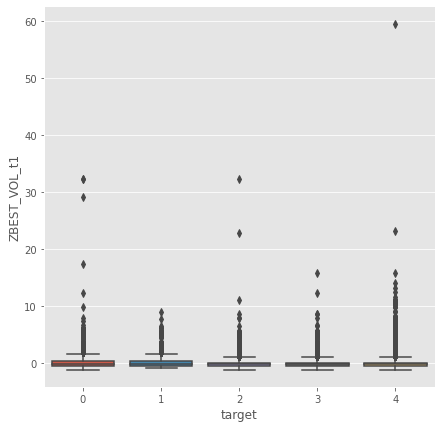

In [14]:
f, ax = plt.subplots(figsize = (7, 7))
# ax.set(yscale = 'log')
sns.boxplot(x = 'target', y = 'ZBEST_VOL_t1', data = train)

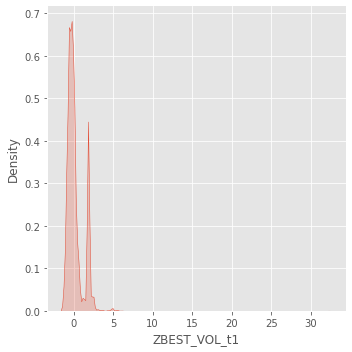

In [23]:
a = train[train['target'] == 0]

sns.displot(data = a, x = 'ZBEST_VOL_t1', kind = 'kde', fill = True)

<AxesSubplot:xlabel='ZBEST_VOL_t1', ylabel='Count'>

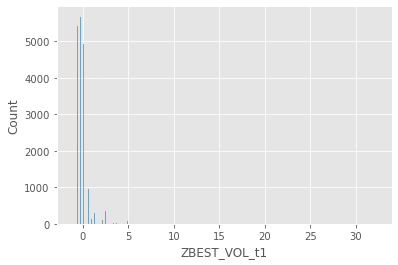

In [24]:
sns.histplot(data = a, x = 'ZBEST_VOL_t1')

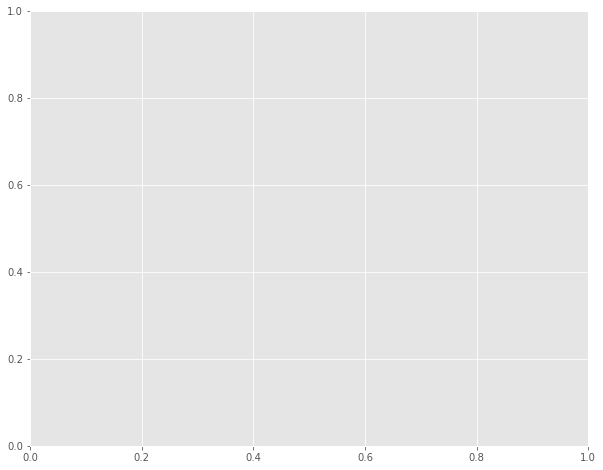

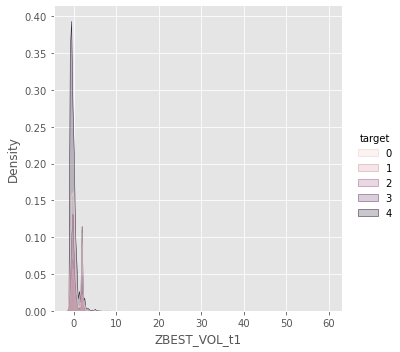

In [20]:
f, ax = plt.subplots(figsize = (10, 8))
sns.displot(data = train, x = 'ZBEST_VOL_t1', hue = 'target', kind = 'kde', fill = True)

In [10]:
train.shape

(113476, 71)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113476 entries, 0 to 113475
Data columns (total 71 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           113476 non-null  int64  
 1   target                       113476 non-null  int64  
 2   Neukunde                     113476 non-null  int64  
 3   AUFNAHME_LOTTERIE            113476 non-null  int64  
 4   TEL_ART                      113476 non-null  int64  
 5   BANKART                      113476 non-null  int64  
 6   WERBEWEG                     113476 non-null  int64  
 7   GESCHLECHT                   113476 non-null  int64  
 8   KUNDEN_ALTER                 113476 non-null  int64  
 9   ALTERSDEZIL                  113476 non-null  int64  
 10  KAUFKRAFTDEZIL               113476 non-null  int64  
 11  ERS_LOS_AUFN                 113476 non-null  int64  
 12  SERVICEWEG_AUF               113476 non-null  int64  
 13 

In [7]:
train.describe()

,id,target,Neukunde,AUFNAHME_LOTTERIE,TEL_ART,BANKART,WERBEWEG,GESCHLECHT,KUNDEN_ALTER,ALTERSDEZIL,KAUFKRAFTDEZIL,ERS_LOS_AUFN,SERVICEWEG_AUF,ZAHLUNGSWEG_AUF,ANZ_GESPIELTE_LOTTERIEN,KKI_INFO_LOTTERIE_VORLOT,KKI_REKLAMATION_LOTT_VORLOT,HGEW,MTKAUG,MTSTAG,MTSTRG,MTBEBG,MTAUSG,MTALTG,MTAJUG,MTAALG,MTFAMG,MTMMOG,MTBONG,MTPOZG,MTWIZG,MTTING,MSBKRG,MSBRKG,klv_scr,tec_scr,ifi_scr,eih_scr,eiw_scr,mtpvvg,mtpzvg,MTKDIG,MTKLEG,MTKKLG,MTKGBG,MTKGLG,MTKPRG,MTKSPG,MTKJAG,MTKDSG,MTKGEG,MTKEMG,MTKOEG,MTKK1K,MTK01G,MTK02G,MTK03G,MTK04G,MTK05G,MTK06G,MTK07G,MTK08G,MTK09G,MTK10G,MTK11G,MTK12G,MTK13G,MTK14G,ablnbl,regio
count,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,113476.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,108600.000000,110059.000000,110059.000000
mean,113530.607380,2.523705,0.363416,115.119171,1.280394,13.064392,4.955021,1.931395,51.427606,7.055245,5.578043,1.870008,1.997506,1.115760,6.880829,0.164934,0.014488,0.187983,0.689926,5.373020,1.504724,1.845037,2.500396,4.441998,4.836667,5.084199,5.102477,4.912891,4.691584,5.205055,5.019862,5.171510,5.507808,4.452284,3.181630,3.653361,3.091630,3.224033,3.075470,5.923637,6.016501,5.398435,5.185129,4.901179,4.894171,1.073379,0.322366,0.234825,2.162726,5.035184,0.186869,4.950792,0.156989,5.565359,1.756308,1.779236,1.875543,1.881611,1.978674,2.057569,1.180626,1.265958,1.681077,0.589208,0.827569,0.953278,1.836740,0.161805,98.162404,20.861165
std,65587.002671,1.655858,0.480985,9.985186,0.631175,4.129937,1.668126,0.995716,21.414731,2.792567,2.989814,0.392297,0.049877,0.319939,9.985186,0.542798,0.126929,1.100705,4.337561,1.972763,0.917923,1.231622,1.858080,1.555798,1.946155,1.950808,1.935674,1.984242,1.958538,1.791852,2.479456,1.951123,1.931104,1.905595,1.534276,1.372553,1.354119,1.505287,1.424533,1.713420,1.823718,1.925527,1.910749,1.961121,1.870701,1.310659,0.844928,0.736974,1.382142,1.946050,0.669557,1.864919,0.643160,2.262777,1.378858,1.404617,1.286183,1.348796,1.175987,1.105417,1.365993,1.323582,1.393226,1.118713,1.232145,1.260033,1.281549,0.681195,0.368823,8.578951
min,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-9.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.000000,12.000000
25%,56617.750000,1.000000,0.000000,115.000000,1.000000,12.000000,3.000000,1.000000,40.000000,5.000000,3.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-3.000000,4.000000,1.000000,1.000000,1.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,5.000000,5.000000,4.000000,4.000000,3.000000,4.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,4.000000,0.0

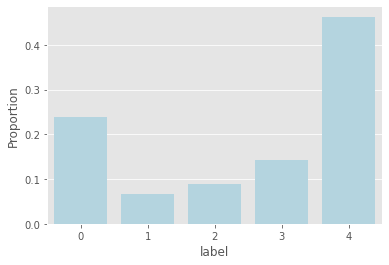

In [4]:
data_plot1 = pd.DataFrame(train['target'].value_counts() / train.shape[0])
data_plot1['label'] = data_plot1.index
data_plot1.columns = ['Proportion', 'label']

sns.barplot(x = 'label', y = 'Proportion', data = data_plot1, color = 'lightblue');

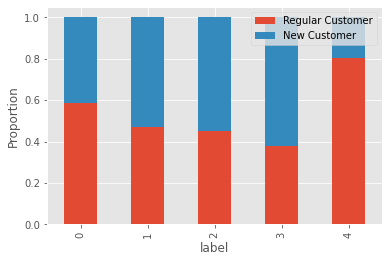

In [3]:
data_plot2 = pd.crosstab(train['target'], train['Neukunde'])
data_plot2.columns = ['Regular Customer', 'New Customer']
data_plot2 = data_plot2.reset_index(drop = True)
data_plot2['Total'] = data_plot2['Regular Customer'] + data_plot2['New Customer']
data_plot2['Regular Customer'] = data_plot2['Regular Customer'] / data_plot2['Total']
data_plot2['New Customer'] = data_plot2['New Customer'] / data_plot2['Total']
data_plot2 = data_plot2.drop(columns = ['Total'], axis = 1)

data_plot2.plot(kind = 'bar', stacked = True)
plt.xlabel('label')
plt.ylabel('Proportion')
plt.show();

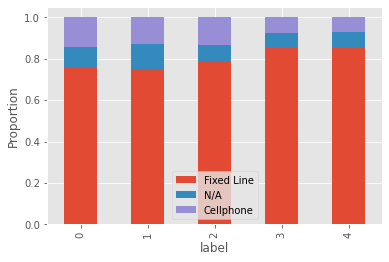

In [4]:
data_plot3 = pd.crosstab(train['target'], train['TEL_ART'])
data_plot3.columns = ['Fixed Line', 'N/A', 'Cellphone']
data_plot3 = data_plot3.reset_index(drop = True)
data_plot3['Total'] = data_plot3['Fixed Line'] + data_plot3['N/A'] + data_plot3['Cellphone']
data_plot3['Fixed Line'] = data_plot3['Fixed Line'] / data_plot3['Total']
data_plot3['N/A'] = data_plot3['N/A'] / data_plot3['Total']
data_plot3['Cellphone'] = data_plot3['Cellphone'] / data_plot3['Total']
data_plot3 = data_plot3.drop(columns = ['Total'], axis = 1)

data_plot3.plot(kind = 'bar', stacked = True)
plt.xlabel('label')
plt.ylabel('Proportion')
plt.show();

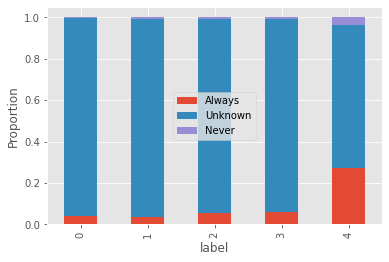

In [10]:
data_plot4 = pd.crosstab(train['target'], train['ERS_LOS_AUFN'])
data_plot4.columns = ['Always', 'Unknown', 'Never']
data_plot4 = data_plot4.reset_index(drop = True)
data_plot4['Total'] = data_plot4['Always'] + data_plot4['Unknown'] + data_plot4['Never']
data_plot4['Always'] = data_plot4['Always'] / data_plot4['Total']
data_plot4['Unknown'] = data_plot4['Unknown'] / data_plot4['Total']
data_plot4['Never'] = data_plot4['Never'] / data_plot4['Total']
data_plot4 = data_plot4.drop(columns = ['Total'], axis = 1)

data_plot4.plot(kind = 'bar', stacked = True)
plt.xlabel('label')
plt.ylabel('Proportion')
plt.show();

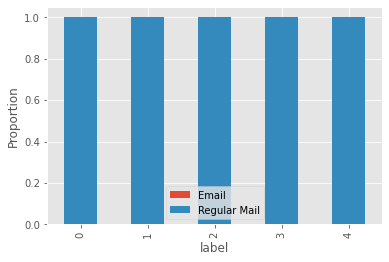

In [13]:
data_plot5 = pd.crosstab(train['target'], train['SERVICEWEG_AUF'])
data_plot5.columns = ['Email', 'Regular Mail']
# data_plot5 = data_plot4.reset_index(drop = True)
data_plot5['Total'] = data_plot5['Email'] + data_plot5['Regular Mail'] 
data_plot5['Email'] = data_plot5['Email'] / data_plot5['Total']
data_plot5['Regular Mail'] = data_plot5['Regular Mail'] / data_plot5['Total']
data_plot5 = data_plot5.drop(columns = ['Total'], axis = 1)

data_plot5.plot(kind = 'bar', stacked = True)
plt.xlabel('label')
plt.ylabel('Proportion')
plt.show();

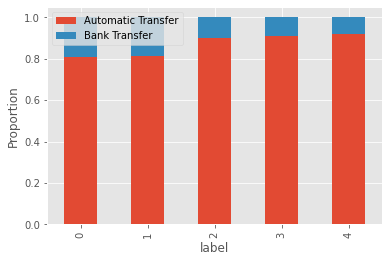

In [16]:
data_plot6 = pd.crosstab(train['target'], train['ZAHLUNGSWEG_AUF'])
data_plot6.columns = ['Automatic Transfer', 'Bank Transfer']
data_plot6['Total'] = data_plot6['Automatic Transfer'] + data_plot6['Bank Transfer'] 
data_plot6['Automatic Transfer'] = data_plot6['Automatic Transfer'] / data_plot6['Total']
data_plot6['Bank Transfer'] = data_plot6['Bank Transfer'] / data_plot6['Total']
data_plot6 = data_plot6.drop(columns = ['Total'], axis = 1)

data_plot6.plot(kind = 'bar', stacked = True)
plt.xlabel('label')
plt.ylabel('Proportion')
plt.show();

In [2]:
data_plot7 = pd.crosstab(train['target'], train['GESCHLECHT'])
# data_plot7.columns = ['Automatic Transfer', 'Bank Transfer']
# data_plot7['Total'] = data_plot7['Automatic Transfer'] + data_plot7['Bank Transfer'] 
# data_plot7['Automatic Transfer'] = data_plot7['Automatic Transfer'] / data_plot7['Total']
# data_plot7['Bank Transfer'] = data_plot7['Bank Transfer'] / data_plot7['Total']
# data_plot7 = data_plot7.drop(columns = ['Total'], axis = 1)

# data_plot7.plot(kind = 'bar', stacked = True)
# plt.xlabel('label')
# plt.ylabel('Proportion')
# plt.show();
data_plot7

WERBEWEG,1,2,3,4,5,6,7
target,,,,,,,
0,437,370,11059,1,1424,12926,877
1,70,93,3335,1,385,3523,214
2,75,151,3799,1,519,5042,448
3,61,310,6512,4,797,7701,830
4,241,1146,15190,18,2597,16111,17208


In [6]:
data_plot7[2]

target
0     370
1      93
2     151
3     310
4    1146
Name: 2, dtype: int64